In [12]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [13]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.2
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [14]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=2),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True, transform=data_transforms['train']),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True, transform=data_transforms['test']),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

### Check Images

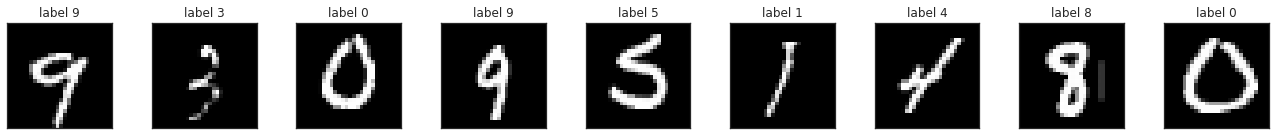

In [15]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [16]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=80)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [17]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs

### Train Teacher Model

==========> Teacher model
03:39:09 --- Epoch: 1	Train loss: 0.2473	Valid loss: 0.1134	Train accuracy: 94.88	Valid accuracy: 96.57
03:39:55 --- Epoch: 3	Train loss: 0.1464	Valid loss: 0.0749	Train accuracy: 96.78	Valid accuracy: 97.60
03:40:42 --- Epoch: 5	Train loss: 0.1131	Valid loss: 0.0631	Train accuracy: 97.29	Valid accuracy: 97.98
03:41:28 --- Epoch: 7	Train loss: 0.0956	Valid loss: 0.0542	Train accuracy: 97.77	Valid accuracy: 98.40
03:42:14 --- Epoch: 9	Train loss: 0.0847	Valid loss: 0.0514	Train accuracy: 97.91	Valid accuracy: 98.42
03:43:00 --- Epoch: 11	Train loss: 0.0754	Valid loss: 0.0450	Train accuracy: 98.15	Valid accuracy: 98.58
03:43:46 --- Epoch: 13	Train loss: 0.0699	Valid loss: 0.0411	Train accuracy: 98.40	Valid accuracy: 98.58
03:44:32 --- Epoch: 15	Train loss: 0.0636	Valid loss: 0.0420	Train accuracy: 98.28	Valid accuracy: 98.59
03:45:18 --- Epoch: 17	Train loss: 0.0587	Valid loss: 0.0396	Train accuracy: 98.54	Valid accuracy: 98.66
03:46:04 --- Epoch: 19	Train loss:

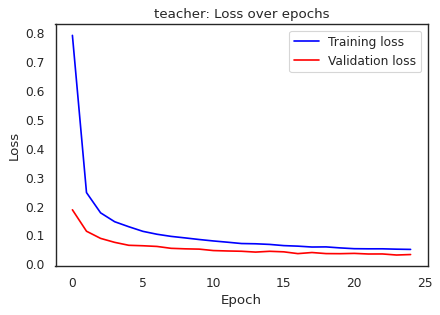


teacher model valid accuracy: 0.9891


In [18]:
print("==========> Teacher model")

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)

LEARNING_RATE = 0.01
N_EPOCHS = 25
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
            "prefix": "teacher",
            "title": "teacher"
            }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, test_loader, DEVICE)
print(f"\nteacher model valid accuracy: {valid_acc:.4f}")

### Train Student Model
#### Q2
Train student model base on groud Truth

=======> Student trained on Ground Truth
03:48:40 --- Epoch: 1	Train loss: 0.2285	Valid loss: 0.1193	Train accuracy: 94.28	Valid accuracy: 96.48
03:49:25 --- Epoch: 3	Train loss: 0.1302	Valid loss: 0.0822	Train accuracy: 96.53	Valid accuracy: 97.37
03:50:11 --- Epoch: 5	Train loss: 0.1008	Valid loss: 0.0675	Train accuracy: 97.31	Valid accuracy: 97.99
03:50:57 --- Epoch: 7	Train loss: 0.0818	Valid loss: 0.0610	Train accuracy: 97.57	Valid accuracy: 98.19
03:51:43 --- Epoch: 9	Train loss: 0.0730	Valid loss: 0.0473	Train accuracy: 98.02	Valid accuracy: 98.56
03:52:28 --- Epoch: 11	Train loss: 0.0635	Valid loss: 0.0467	Train accuracy: 98.07	Valid accuracy: 98.53
03:53:14 --- Epoch: 13	Train loss: 0.0593	Valid loss: 0.0421	Train accuracy: 98.30	Valid accuracy: 98.53
03:54:00 --- Epoch: 15	Train loss: 0.0523	Valid loss: 0.0348	Train accuracy: 98.59	Valid accuracy: 98.80
03:54:46 --- Epoch: 17	Train loss: 0.0487	Valid loss: 0.0403	Train accuracy: 98.54	Valid accuracy: 98.61
03:55:31 --- Epoch:

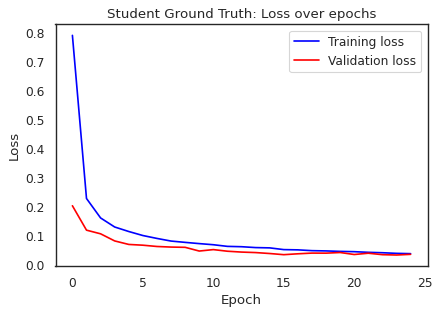


student model valid accuracy: 0.9876


In [19]:
print(f"=======> Student trained on Ground Truth")

LEARNING_RATE = 0.01
N_EPOCHS = 25

model_s_true = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true, optimizer, _ = training_loop(model_s_true, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2)
torch.save(model_s_true.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

Train student model base on teacher's soft label

=======> Student trained on Soft Label
03:58:06 --- Epoch: 1	Train loss: 0.2873	Valid loss: 0.0469	Train accuracy: 97.89	Valid accuracy: 98.41
03:58:53 --- Epoch: 3	Train loss: 0.1495	Valid loss: 0.0411	Train accuracy: 98.13	Valid accuracy: 98.74
03:59:40 --- Epoch: 5	Train loss: 0.1148	Valid loss: 0.0389	Train accuracy: 98.44	Valid accuracy: 98.80
04:00:27 --- Epoch: 7	Train loss: 0.0972	Valid loss: 0.0367	Train accuracy: 98.43	Valid accuracy: 98.82
04:01:14 --- Epoch: 9	Train loss: 0.0879	Valid loss: 0.0360	Train accuracy: 98.50	Valid accuracy: 98.87
04:02:01 --- Epoch: 11	Train loss: 0.0790	Valid loss: 0.0344	Train accuracy: 98.60	Valid accuracy: 98.88
04:02:47 --- Epoch: 13	Train loss: 0.0742	Valid loss: 0.0349	Train accuracy: 98.69	Valid accuracy: 98.86
04:03:34 --- Epoch: 15	Train loss: 0.0701	Valid loss: 0.0343	Train accuracy: 98.66	Valid accuracy: 98.92
04:04:20 --- Epoch: 17	Train loss: 0.0664	Valid loss: 0.0339	Train accuracy: 98.71	Valid accuracy: 98.89
04:05:07 --- Epoch: 1

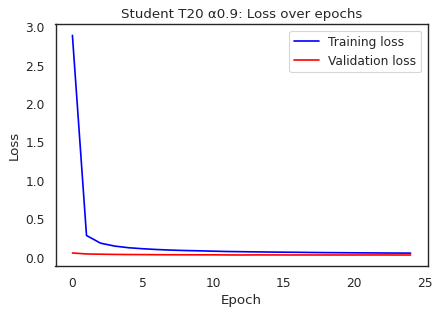


student model valid accuracy: 0.9892


In [20]:
# Train
LEARNING_RATE = 0.01
N_EPOCHS = 25
ALPHA = 0.9

print(f"=======> Student trained on Soft Label")
model_s_soft = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE, momentum=0.9)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  

valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

#### Q3
Different Temprature

=======> Temperature: 0.1
=======> Teacher model trained with Temperature 0.1
04:07:44 --- Epoch: 1	Train loss: 0.2464	Valid loss: 0.1138	Train accuracy: 94.82	Valid accuracy: 96.43
04:08:29 --- Epoch: 3	Train loss: 0.1461	Valid loss: 0.0818	Train accuracy: 96.50	Valid accuracy: 97.39
04:09:14 --- Epoch: 5	Train loss: 0.1136	Valid loss: 0.0685	Train accuracy: 97.18	Valid accuracy: 97.84
04:09:58 --- Epoch: 7	Train loss: 0.0967	Valid loss: 0.0556	Train accuracy: 97.69	Valid accuracy: 98.27
04:10:44 --- Epoch: 9	Train loss: 0.0845	Valid loss: 0.0483	Train accuracy: 97.98	Valid accuracy: 98.46
04:11:28 --- Epoch: 11	Train loss: 0.0739	Valid loss: 0.0455	Train accuracy: 98.08	Valid accuracy: 98.51
04:12:14 --- Epoch: 13	Train loss: 0.0675	Valid loss: 0.0463	Train accuracy: 98.33	Valid accuracy: 98.38
04:12:59 --- Epoch: 15	Train loss: 0.0645	Valid loss: 0.0376	Train accuracy: 98.48	Valid accuracy: 98.70
04:13:44 --- Epoch: 17	Train loss: 0.0598	Valid loss: 0.0343	Train accuracy: 98.69	Vali

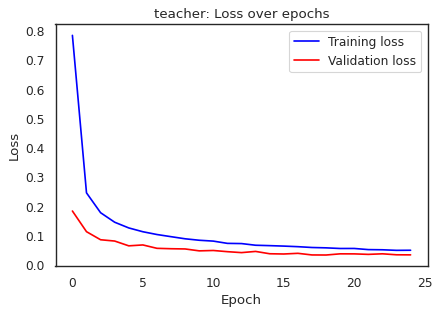

=======> Student model trained with Temperature 0.1
04:17:01 --- Epoch: 1	Train loss: 0.1204	Valid loss: 0.6010	Train accuracy: 78.27	Valid accuracy: 88.51
04:17:46 --- Epoch: 3	Train loss: 0.0695	Valid loss: 0.3455	Train accuracy: 88.30	Valid accuracy: 93.78
04:18:32 --- Epoch: 5	Train loss: 0.0431	Valid loss: 0.2342	Train accuracy: 92.25	Valid accuracy: 95.30
04:19:18 --- Epoch: 7	Train loss: 0.0317	Valid loss: 0.1794	Train accuracy: 93.88	Valid accuracy: 95.97
04:20:03 --- Epoch: 9	Train loss: 0.0263	Valid loss: 0.1388	Train accuracy: 95.05	Valid accuracy: 96.83
04:20:49 --- Epoch: 11	Train loss: 0.0225	Valid loss: 0.1205	Train accuracy: 95.60	Valid accuracy: 96.94
04:21:34 --- Epoch: 13	Train loss: 0.0199	Valid loss: 0.1067	Train accuracy: 95.99	Valid accuracy: 97.28
04:22:20 --- Epoch: 15	Train loss: 0.0178	Valid loss: 0.0980	Train accuracy: 96.37	Valid accuracy: 97.25
04:23:06 --- Epoch: 17	Train loss: 0.0164	Valid loss: 0.0919	Train accuracy: 96.58	Valid accuracy: 97.39
04:23:52

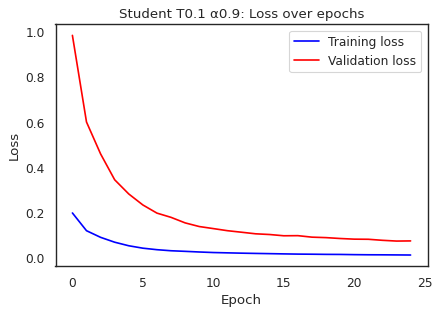


student model valid accuracy: 0.9793
=======> Temperature: 0.30000000000000004
=======> Teacher model trained with Temperature 0.30000000000000004
04:26:26 --- Epoch: 1	Train loss: 0.2444	Valid loss: 0.1122	Train accuracy: 94.83	Valid accuracy: 96.61
04:27:11 --- Epoch: 3	Train loss: 0.1476	Valid loss: 0.0710	Train accuracy: 96.71	Valid accuracy: 97.90
04:27:56 --- Epoch: 5	Train loss: 0.1114	Valid loss: 0.0614	Train accuracy: 97.31	Valid accuracy: 98.07
04:28:42 --- Epoch: 7	Train loss: 0.0960	Valid loss: 0.0509	Train accuracy: 97.71	Valid accuracy: 98.33
04:29:28 --- Epoch: 9	Train loss: 0.0849	Valid loss: 0.0502	Train accuracy: 97.91	Valid accuracy: 98.41
04:30:13 --- Epoch: 11	Train loss: 0.0761	Valid loss: 0.0443	Train accuracy: 98.18	Valid accuracy: 98.55
04:30:57 --- Epoch: 13	Train loss: 0.0689	Valid loss: 0.0396	Train accuracy: 98.47	Valid accuracy: 98.73
04:31:42 --- Epoch: 15	Train loss: 0.0647	Valid loss: 0.0418	Train accuracy: 98.39	Valid accuracy: 98.70
04:32:28 --- Epoc

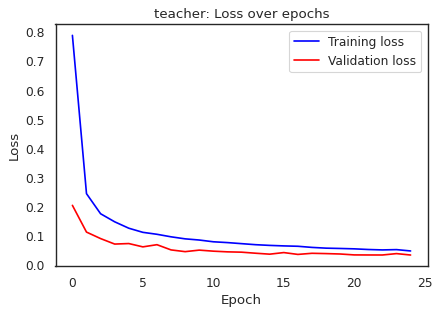

=======> Student model trained with Temperature 0.30000000000000004
04:35:45 --- Epoch: 1	Train loss: 0.1251	Valid loss: 0.4902	Train accuracy: 87.48	Valid accuracy: 93.14
04:36:33 --- Epoch: 3	Train loss: 0.0580	Valid loss: 0.2454	Train accuracy: 93.66	Valid accuracy: 96.16
04:37:21 --- Epoch: 5	Train loss: 0.0395	Valid loss: 0.1680	Train accuracy: 95.25	Valid accuracy: 96.93
04:38:08 --- Epoch: 7	Train loss: 0.0314	Valid loss: 0.1335	Train accuracy: 95.89	Valid accuracy: 97.30
04:38:56 --- Epoch: 9	Train loss: 0.0260	Valid loss: 0.1157	Train accuracy: 96.34	Valid accuracy: 97.37
04:39:44 --- Epoch: 11	Train loss: 0.0232	Valid loss: 0.1062	Train accuracy: 96.68	Valid accuracy: 97.41
04:40:32 --- Epoch: 13	Train loss: 0.0204	Valid loss: 0.0919	Train accuracy: 97.24	Valid accuracy: 97.79
04:41:20 --- Epoch: 15	Train loss: 0.0180	Valid loss: 0.0855	Train accuracy: 97.23	Valid accuracy: 97.86
04:42:09 --- Epoch: 17	Train loss: 0.0168	Valid loss: 0.0778	Train accuracy: 97.45	Valid accuracy

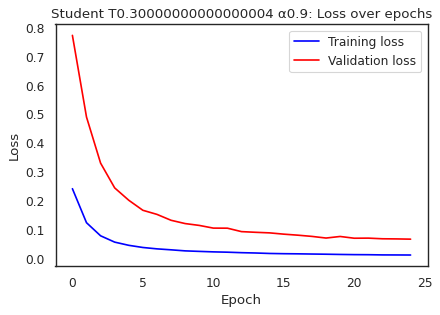


student model valid accuracy: 0.9820
=======> Temperature: 0.5000000000000001
=======> Teacher model trained with Temperature 0.5000000000000001
04:45:36 --- Epoch: 1	Train loss: 0.2456	Valid loss: 0.1212	Train accuracy: 94.77	Valid accuracy: 96.43
04:46:24 --- Epoch: 3	Train loss: 0.1428	Valid loss: 0.0747	Train accuracy: 96.71	Valid accuracy: 97.74
04:47:10 --- Epoch: 5	Train loss: 0.1147	Valid loss: 0.0657	Train accuracy: 97.31	Valid accuracy: 97.90
04:47:56 --- Epoch: 7	Train loss: 0.0966	Valid loss: 0.0524	Train accuracy: 97.73	Valid accuracy: 98.35
04:48:43 --- Epoch: 9	Train loss: 0.0847	Valid loss: 0.0433	Train accuracy: 98.07	Valid accuracy: 98.63
04:49:29 --- Epoch: 11	Train loss: 0.0752	Valid loss: 0.0429	Train accuracy: 98.23	Valid accuracy: 98.64
04:50:15 --- Epoch: 13	Train loss: 0.0694	Valid loss: 0.0375	Train accuracy: 98.43	Valid accuracy: 98.80
04:51:02 --- Epoch: 15	Train loss: 0.0641	Valid loss: 0.0406	Train accuracy: 98.55	Valid accuracy: 98.71
04:51:49 --- Epoch:

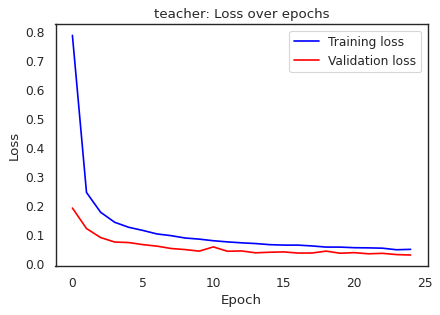

=======> Student model trained with Temperature 0.5000000000000001
04:55:15 --- Epoch: 1	Train loss: 0.1330	Valid loss: 0.3009	Train accuracy: 91.94	Valid accuracy: 95.44
04:56:03 --- Epoch: 3	Train loss: 0.0585	Valid loss: 0.1687	Train accuracy: 95.23	Valid accuracy: 96.73
04:56:52 --- Epoch: 5	Train loss: 0.0408	Valid loss: 0.1312	Train accuracy: 96.00	Valid accuracy: 97.19
04:57:40 --- Epoch: 7	Train loss: 0.0330	Valid loss: 0.1050	Train accuracy: 96.58	Valid accuracy: 97.57
04:58:29 --- Epoch: 9	Train loss: 0.0274	Valid loss: 0.0911	Train accuracy: 97.06	Valid accuracy: 97.98
04:59:17 --- Epoch: 11	Train loss: 0.0237	Valid loss: 0.0859	Train accuracy: 97.31	Valid accuracy: 97.80
05:00:06 --- Epoch: 13	Train loss: 0.0207	Valid loss: 0.0737	Train accuracy: 97.62	Valid accuracy: 98.12
05:00:54 --- Epoch: 15	Train loss: 0.0187	Valid loss: 0.0672	Train accuracy: 97.77	Valid accuracy: 98.29
05:01:43 --- Epoch: 17	Train loss: 0.0169	Valid loss: 0.0638	Train accuracy: 97.84	Valid accuracy:

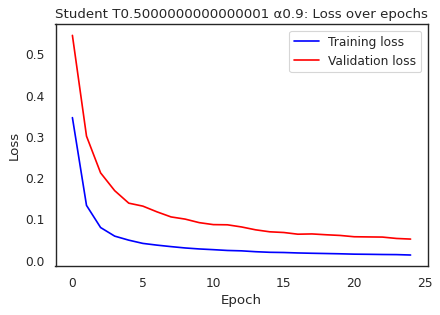


student model valid accuracy: 0.9856
=======> Temperature: 0.7000000000000001
=======> Teacher model trained with Temperature 0.7000000000000001
05:05:15 --- Epoch: 1	Train loss: 0.2434	Valid loss: 0.1260	Train accuracy: 94.41	Valid accuracy: 96.23
05:06:02 --- Epoch: 3	Train loss: 0.1463	Valid loss: 0.0802	Train accuracy: 96.67	Valid accuracy: 97.68
05:06:49 --- Epoch: 5	Train loss: 0.1100	Valid loss: 0.0645	Train accuracy: 97.10	Valid accuracy: 98.01
05:07:36 --- Epoch: 7	Train loss: 0.0942	Valid loss: 0.0512	Train accuracy: 97.71	Valid accuracy: 98.43
05:08:22 --- Epoch: 9	Train loss: 0.0849	Valid loss: 0.0497	Train accuracy: 98.09	Valid accuracy: 98.41
05:09:10 --- Epoch: 11	Train loss: 0.0749	Valid loss: 0.0429	Train accuracy: 98.20	Valid accuracy: 98.53
05:09:57 --- Epoch: 13	Train loss: 0.0685	Valid loss: 0.0398	Train accuracy: 98.44	Valid accuracy: 98.83
05:10:44 --- Epoch: 15	Train loss: 0.0625	Valid loss: 0.0362	Train accuracy: 98.56	Valid accuracy: 98.75
05:11:30 --- Epoch:

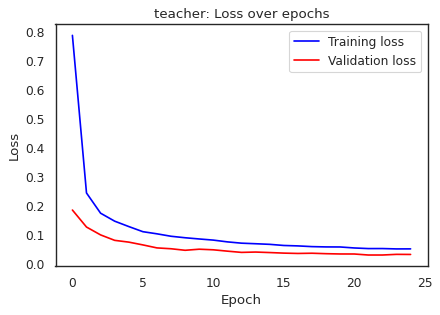

=======> Student model trained with Temperature 0.7000000000000001
05:14:55 --- Epoch: 1	Train loss: 0.1473	Valid loss: 0.1886	Train accuracy: 93.41	Valid accuracy: 96.04
05:15:43 --- Epoch: 3	Train loss: 0.0646	Valid loss: 0.1112	Train accuracy: 95.96	Valid accuracy: 97.24
05:16:31 --- Epoch: 5	Train loss: 0.0460	Valid loss: 0.0865	Train accuracy: 96.85	Valid accuracy: 97.70
05:17:17 --- Epoch: 7	Train loss: 0.0355	Valid loss: 0.0750	Train accuracy: 97.17	Valid accuracy: 97.93
05:18:05 --- Epoch: 9	Train loss: 0.0291	Valid loss: 0.0655	Train accuracy: 97.55	Valid accuracy: 98.01
05:18:52 --- Epoch: 11	Train loss: 0.0243	Valid loss: 0.0600	Train accuracy: 97.85	Valid accuracy: 98.36
05:19:40 --- Epoch: 13	Train loss: 0.0212	Valid loss: 0.0579	Train accuracy: 97.94	Valid accuracy: 98.32
05:20:27 --- Epoch: 15	Train loss: 0.0191	Valid loss: 0.0565	Train accuracy: 98.03	Valid accuracy: 98.42
05:21:14 --- Epoch: 17	Train loss: 0.0167	Valid loss: 0.0480	Train accuracy: 98.21	Valid accuracy:

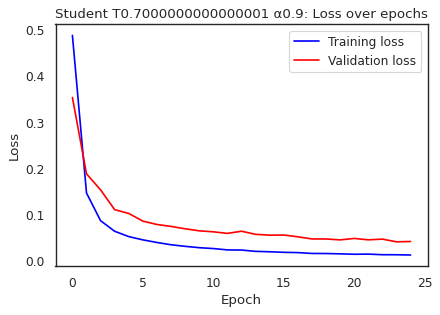


student model valid accuracy: 0.9877
=======> Temperature: 0.9000000000000001
=======> Teacher model trained with Temperature 0.9000000000000001
05:24:41 --- Epoch: 1	Train loss: 0.2460	Valid loss: 0.1172	Train accuracy: 95.05	Valid accuracy: 96.83
05:25:28 --- Epoch: 3	Train loss: 0.1484	Valid loss: 0.0746	Train accuracy: 96.65	Valid accuracy: 97.62
05:26:15 --- Epoch: 5	Train loss: 0.1146	Valid loss: 0.0636	Train accuracy: 97.26	Valid accuracy: 97.79
05:27:02 --- Epoch: 7	Train loss: 0.0962	Valid loss: 0.0554	Train accuracy: 97.79	Valid accuracy: 98.21
05:27:50 --- Epoch: 9	Train loss: 0.0873	Valid loss: 0.0503	Train accuracy: 98.01	Valid accuracy: 98.39
05:28:37 --- Epoch: 11	Train loss: 0.0756	Valid loss: 0.0423	Train accuracy: 98.24	Valid accuracy: 98.65
05:29:25 --- Epoch: 13	Train loss: 0.0706	Valid loss: 0.0423	Train accuracy: 98.23	Valid accuracy: 98.48
05:30:11 --- Epoch: 15	Train loss: 0.0641	Valid loss: 0.0389	Train accuracy: 98.51	Valid accuracy: 98.62
05:30:58 --- Epoch:

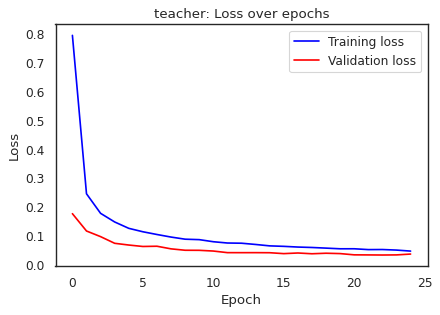

=======> Student model trained with Temperature 0.9000000000000001
05:34:24 --- Epoch: 1	Train loss: 0.1680	Valid loss: 0.1504	Train accuracy: 94.35	Valid accuracy: 95.79
05:35:12 --- Epoch: 3	Train loss: 0.0789	Valid loss: 0.0861	Train accuracy: 96.38	Valid accuracy: 97.41
05:36:00 --- Epoch: 5	Train loss: 0.0526	Valid loss: 0.0711	Train accuracy: 96.75	Valid accuracy: 97.68
05:36:48 --- Epoch: 7	Train loss: 0.0394	Valid loss: 0.0682	Train accuracy: 97.36	Valid accuracy: 97.84
05:37:36 --- Epoch: 9	Train loss: 0.0334	Valid loss: 0.0555	Train accuracy: 97.64	Valid accuracy: 98.15
05:38:24 --- Epoch: 11	Train loss: 0.0278	Valid loss: 0.0533	Train accuracy: 98.09	Valid accuracy: 98.32
05:39:12 --- Epoch: 13	Train loss: 0.0232	Valid loss: 0.0495	Train accuracy: 98.06	Valid accuracy: 98.45
05:40:00 --- Epoch: 15	Train loss: 0.0208	Valid loss: 0.0469	Train accuracy: 98.28	Valid accuracy: 98.50
05:40:48 --- Epoch: 17	Train loss: 0.0184	Valid loss: 0.0435	Train accuracy: 98.27	Valid accuracy:

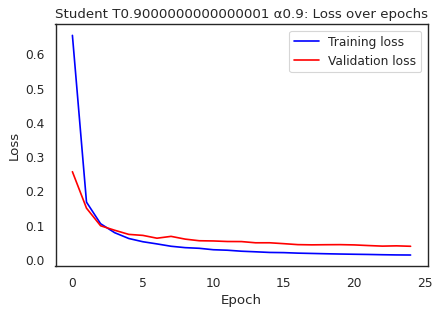


student model valid accuracy: 0.9869


In [21]:
# Train
LEARNING_RATE_T = 0.01
LEARNING_RATE_S = 0.01
N_EPOCHS = 25
ALPHA = 0.9

for T in np.arange(0.1, 1, 0.2):
    print(f"=======> Temperature: {T}")
    print(f"=======> Teacher model trained with Temperature {T}")
    model_teacher = LargeNet(N_CLASSES, DROPOUT, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE_T, momentum=0.9)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

    print(f"=======> Student model trained with Temperature {T}")
    model_s_soft = SmallNet(N_CLASSES, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE_S, momentum=0.9)
    
    train_criterion = SoftCrossEntropyLoss(T, ALPHA)
    valid_criterion = nn.CrossEntropyLoss()
    
    prefix = f"student_T{T}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{T} α{ALPHA}"
         }

    model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
    torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")
    
    valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
    print(f"\nstudent model valid accuracy: {valid_acc:.4f}")


=======> Temperature: 30
=======> Teacher model trained with Temperature 30
06:17:45 --- Epoch: 1	Train loss: 0.2438	Valid loss: 0.1171	Train accuracy: 94.90	Valid accuracy: 96.53
06:18:33 --- Epoch: 3	Train loss: 0.1461	Valid loss: 0.0833	Train accuracy: 96.36	Valid accuracy: 97.37
06:19:20 --- Epoch: 5	Train loss: 0.1138	Valid loss: 0.0651	Train accuracy: 97.29	Valid accuracy: 98.03
06:20:08 --- Epoch: 7	Train loss: 0.0953	Valid loss: 0.0488	Train accuracy: 97.68	Valid accuracy: 98.40
06:20:55 --- Epoch: 9	Train loss: 0.0821	Valid loss: 0.0442	Train accuracy: 98.04	Valid accuracy: 98.67
06:21:42 --- Epoch: 11	Train loss: 0.0749	Valid loss: 0.0448	Train accuracy: 98.24	Valid accuracy: 98.50
06:22:30 --- Epoch: 13	Train loss: 0.0706	Valid loss: 0.0414	Train accuracy: 98.32	Valid accuracy: 98.74
06:23:17 --- Epoch: 15	Train loss: 0.0635	Valid loss: 0.0373	Train accuracy: 98.38	Valid accuracy: 98.88
06:24:04 --- Epoch: 17	Train loss: 0.0600	Valid loss: 0.0386	Train accuracy: 98.64	Valid 

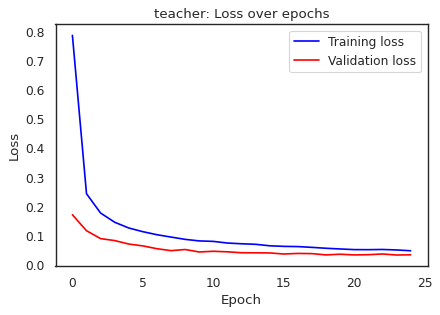

=======> Student model trained with Temperature 30
06:27:33 --- Epoch: 1	Train loss: 0.3087	Valid loss: 0.0468	Train accuracy: 97.77	Valid accuracy: 98.49
06:28:22 --- Epoch: 3	Train loss: 0.1562	Valid loss: 0.0426	Train accuracy: 98.17	Valid accuracy: 98.58
06:29:11 --- Epoch: 5	Train loss: 0.1198	Valid loss: 0.0413	Train accuracy: 98.33	Valid accuracy: 98.66
06:29:59 --- Epoch: 7	Train loss: 0.1017	Valid loss: 0.0380	Train accuracy: 98.52	Valid accuracy: 98.74
06:30:49 --- Epoch: 9	Train loss: 0.0901	Valid loss: 0.0380	Train accuracy: 98.58	Valid accuracy: 98.77
06:31:38 --- Epoch: 11	Train loss: 0.0831	Valid loss: 0.0382	Train accuracy: 98.55	Valid accuracy: 98.81
06:32:27 --- Epoch: 13	Train loss: 0.0766	Valid loss: 0.0379	Train accuracy: 98.66	Valid accuracy: 98.79
06:33:15 --- Epoch: 15	Train loss: 0.0719	Valid loss: 0.0377	Train accuracy: 98.69	Valid accuracy: 98.83
06:34:04 --- Epoch: 17	Train loss: 0.0686	Valid loss: 0.0369	Train accuracy: 98.68	Valid accuracy: 98.84
06:34:52 

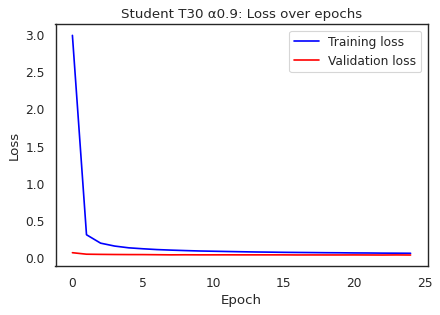


student model valid accuracy: 0.9890
=======> Temperature: 40
=======> Teacher model trained with Temperature 40
06:37:37 --- Epoch: 1	Train loss: 0.2451	Valid loss: 0.1092	Train accuracy: 94.87	Valid accuracy: 96.84
06:38:24 --- Epoch: 3	Train loss: 0.1467	Valid loss: 0.0718	Train accuracy: 96.78	Valid accuracy: 97.74
06:39:10 --- Epoch: 5	Train loss: 0.1135	Valid loss: 0.0714	Train accuracy: 97.15	Valid accuracy: 97.77
06:39:57 --- Epoch: 7	Train loss: 0.0961	Valid loss: 0.0532	Train accuracy: 97.71	Valid accuracy: 98.31
06:40:44 --- Epoch: 9	Train loss: 0.0840	Valid loss: 0.0516	Train accuracy: 97.83	Valid accuracy: 98.33
06:41:30 --- Epoch: 11	Train loss: 0.0747	Valid loss: 0.0432	Train accuracy: 98.27	Valid accuracy: 98.48
06:42:17 --- Epoch: 13	Train loss: 0.0678	Valid loss: 0.0426	Train accuracy: 98.35	Valid accuracy: 98.65
06:43:03 --- Epoch: 15	Train loss: 0.0648	Valid loss: 0.0363	Train accuracy: 98.51	Valid accuracy: 98.87
06:43:48 --- Epoch: 17	Train loss: 0.0604	Valid los

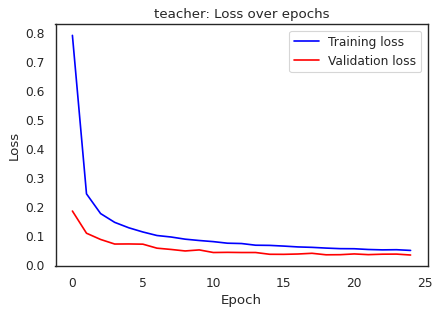

=======> Student model trained with Temperature 40
06:47:08 --- Epoch: 1	Train loss: 0.3002	Valid loss: 0.0499	Train accuracy: 97.75	Valid accuracy: 98.39
06:47:56 --- Epoch: 3	Train loss: 0.1491	Valid loss: 0.0433	Train accuracy: 98.15	Valid accuracy: 98.53
06:48:44 --- Epoch: 5	Train loss: 0.1138	Valid loss: 0.0393	Train accuracy: 98.33	Valid accuracy: 98.69
06:49:33 --- Epoch: 7	Train loss: 0.0979	Valid loss: 0.0384	Train accuracy: 98.41	Valid accuracy: 98.79
06:50:22 --- Epoch: 9	Train loss: 0.0876	Valid loss: 0.0377	Train accuracy: 98.53	Valid accuracy: 98.73
06:51:11 --- Epoch: 11	Train loss: 0.0798	Valid loss: 0.0369	Train accuracy: 98.56	Valid accuracy: 98.78
06:52:01 --- Epoch: 13	Train loss: 0.0748	Valid loss: 0.0362	Train accuracy: 98.61	Valid accuracy: 98.77
06:52:51 --- Epoch: 15	Train loss: 0.0695	Valid loss: 0.0362	Train accuracy: 98.64	Valid accuracy: 98.80
06:53:40 --- Epoch: 17	Train loss: 0.0662	Valid loss: 0.0362	Train accuracy: 98.59	Valid accuracy: 98.75
06:54:28 

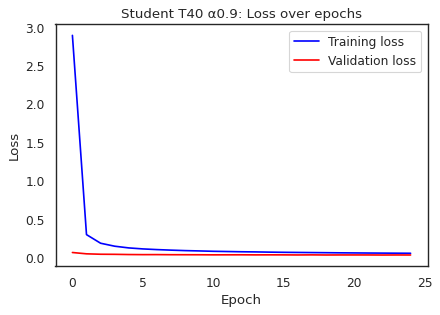


student model valid accuracy: 0.9880
=======> Temperature: 50
=======> Teacher model trained with Temperature 50
06:57:13 --- Epoch: 1	Train loss: 0.2482	Valid loss: 0.1099	Train accuracy: 95.00	Valid accuracy: 96.80
06:58:01 --- Epoch: 3	Train loss: 0.1450	Valid loss: 0.0743	Train accuracy: 96.73	Valid accuracy: 97.81
06:58:48 --- Epoch: 5	Train loss: 0.1114	Valid loss: 0.0646	Train accuracy: 97.02	Valid accuracy: 97.96
06:59:35 --- Epoch: 7	Train loss: 0.0945	Valid loss: 0.0516	Train accuracy: 97.70	Valid accuracy: 98.32
07:00:22 --- Epoch: 9	Train loss: 0.0828	Valid loss: 0.0475	Train accuracy: 98.06	Valid accuracy: 98.51
07:01:09 --- Epoch: 11	Train loss: 0.0745	Valid loss: 0.0464	Train accuracy: 98.20	Valid accuracy: 98.45
07:01:56 --- Epoch: 13	Train loss: 0.0686	Valid loss: 0.0389	Train accuracy: 98.46	Valid accuracy: 98.74
07:02:43 --- Epoch: 15	Train loss: 0.0657	Valid loss: 0.0364	Train accuracy: 98.51	Valid accuracy: 98.81
07:03:31 --- Epoch: 17	Train loss: 0.0592	Valid los

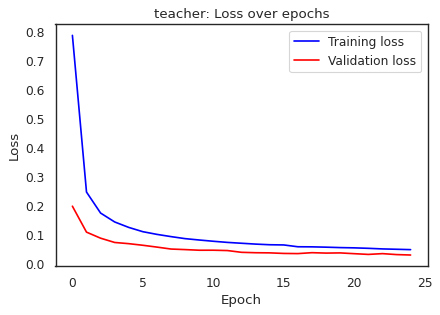

=======> Student model trained with Temperature 50
07:06:57 --- Epoch: 1	Train loss: 0.3012	Valid loss: 0.0467	Train accuracy: 97.76	Valid accuracy: 98.32
07:07:46 --- Epoch: 3	Train loss: 0.1523	Valid loss: 0.0386	Train accuracy: 98.18	Valid accuracy: 98.78
07:08:33 --- Epoch: 5	Train loss: 0.1156	Valid loss: 0.0362	Train accuracy: 98.42	Valid accuracy: 98.79
07:09:22 --- Epoch: 7	Train loss: 0.0988	Valid loss: 0.0352	Train accuracy: 98.48	Valid accuracy: 98.79
07:10:10 --- Epoch: 9	Train loss: 0.0887	Valid loss: 0.0342	Train accuracy: 98.54	Valid accuracy: 98.85
07:10:58 --- Epoch: 11	Train loss: 0.0812	Valid loss: 0.0340	Train accuracy: 98.56	Valid accuracy: 98.85
07:11:46 --- Epoch: 13	Train loss: 0.0750	Valid loss: 0.0339	Train accuracy: 98.61	Valid accuracy: 98.84
07:12:35 --- Epoch: 15	Train loss: 0.0706	Valid loss: 0.0329	Train accuracy: 98.71	Valid accuracy: 98.91
07:13:22 --- Epoch: 17	Train loss: 0.0679	Valid loss: 0.0334	Train accuracy: 98.66	Valid accuracy: 98.85
07:14:10 

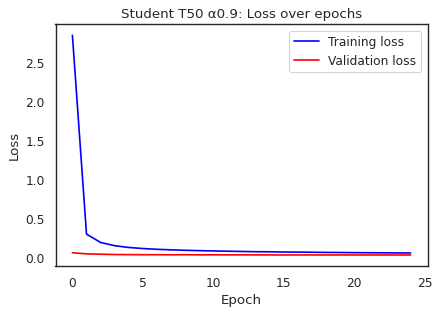


student model valid accuracy: 0.9893
=======> Temperature: 60
=======> Teacher model trained with Temperature 60
07:16:53 --- Epoch: 1	Train loss: 0.2466	Valid loss: 0.1161	Train accuracy: 94.97	Valid accuracy: 96.67
07:17:41 --- Epoch: 3	Train loss: 0.1444	Valid loss: 0.0728	Train accuracy: 96.71	Valid accuracy: 97.79
07:18:28 --- Epoch: 5	Train loss: 0.1145	Valid loss: 0.0657	Train accuracy: 97.17	Valid accuracy: 97.96
07:19:15 --- Epoch: 7	Train loss: 0.0967	Valid loss: 0.0514	Train accuracy: 97.78	Valid accuracy: 98.36
07:20:02 --- Epoch: 9	Train loss: 0.0853	Valid loss: 0.0464	Train accuracy: 98.11	Valid accuracy: 98.53
07:20:49 --- Epoch: 11	Train loss: 0.0735	Valid loss: 0.0435	Train accuracy: 98.23	Valid accuracy: 98.55
07:21:35 --- Epoch: 13	Train loss: 0.0695	Valid loss: 0.0461	Train accuracy: 98.26	Valid accuracy: 98.57
07:22:22 --- Epoch: 15	Train loss: 0.0645	Valid loss: 0.0399	Train accuracy: 98.48	Valid accuracy: 98.68
07:23:09 --- Epoch: 17	Train loss: 0.0611	Valid los

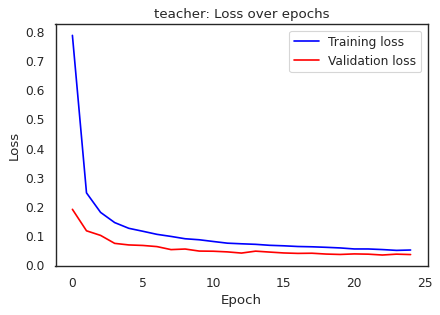

=======> Student model trained with Temperature 60
07:26:33 --- Epoch: 1	Train loss: 0.2923	Valid loss: 0.0485	Train accuracy: 97.62	Valid accuracy: 98.25
07:27:21 --- Epoch: 3	Train loss: 0.1496	Valid loss: 0.0413	Train accuracy: 98.15	Valid accuracy: 98.49
07:28:10 --- Epoch: 5	Train loss: 0.1153	Valid loss: 0.0391	Train accuracy: 98.35	Valid accuracy: 98.57
07:28:59 --- Epoch: 7	Train loss: 0.0995	Valid loss: 0.0376	Train accuracy: 98.42	Valid accuracy: 98.64
07:29:47 --- Epoch: 9	Train loss: 0.0879	Valid loss: 0.0377	Train accuracy: 98.52	Valid accuracy: 98.62
07:30:35 --- Epoch: 11	Train loss: 0.0809	Valid loss: 0.0365	Train accuracy: 98.61	Valid accuracy: 98.62
07:31:24 --- Epoch: 13	Train loss: 0.0755	Valid loss: 0.0355	Train accuracy: 98.56	Valid accuracy: 98.68
07:32:13 --- Epoch: 15	Train loss: 0.0719	Valid loss: 0.0348	Train accuracy: 98.60	Valid accuracy: 98.71
07:33:01 --- Epoch: 17	Train loss: 0.0684	Valid loss: 0.0357	Train accuracy: 98.66	Valid accuracy: 98.69
07:33:49 

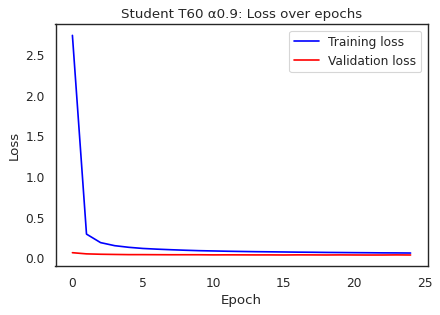


student model valid accuracy: 0.9876
=======> Temperature: 70
=======> Teacher model trained with Temperature 70
07:36:30 --- Epoch: 1	Train loss: 0.2443	Valid loss: 0.1132	Train accuracy: 94.98	Valid accuracy: 96.58
07:37:17 --- Epoch: 3	Train loss: 0.1449	Valid loss: 0.0796	Train accuracy: 96.76	Valid accuracy: 97.68
07:38:03 --- Epoch: 5	Train loss: 0.1122	Valid loss: 0.0632	Train accuracy: 97.19	Valid accuracy: 98.02
07:38:50 --- Epoch: 7	Train loss: 0.0973	Valid loss: 0.0508	Train accuracy: 97.78	Valid accuracy: 98.35
07:39:36 --- Epoch: 9	Train loss: 0.0840	Valid loss: 0.0490	Train accuracy: 97.94	Valid accuracy: 98.41
07:40:23 --- Epoch: 11	Train loss: 0.0774	Valid loss: 0.0471	Train accuracy: 98.21	Valid accuracy: 98.42
07:41:10 --- Epoch: 13	Train loss: 0.0697	Valid loss: 0.0412	Train accuracy: 98.47	Valid accuracy: 98.66
07:41:58 --- Epoch: 15	Train loss: 0.0650	Valid loss: 0.0368	Train accuracy: 98.50	Valid accuracy: 98.84
07:42:45 --- Epoch: 17	Train loss: 0.0603	Valid los

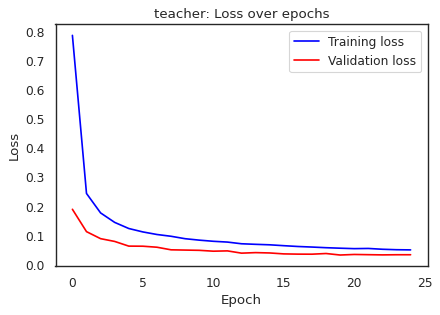

=======> Student model trained with Temperature 70
07:46:10 --- Epoch: 1	Train loss: 0.2911	Valid loss: 0.0495	Train accuracy: 97.72	Valid accuracy: 98.30
07:46:59 --- Epoch: 3	Train loss: 0.1472	Valid loss: 0.0425	Train accuracy: 98.19	Valid accuracy: 98.59
07:47:47 --- Epoch: 5	Train loss: 0.1136	Valid loss: 0.0378	Train accuracy: 98.27	Valid accuracy: 98.70
07:48:36 --- Epoch: 7	Train loss: 0.0970	Valid loss: 0.0376	Train accuracy: 98.45	Valid accuracy: 98.69
07:49:25 --- Epoch: 9	Train loss: 0.0874	Valid loss: 0.0360	Train accuracy: 98.44	Valid accuracy: 98.83
07:50:13 --- Epoch: 11	Train loss: 0.0796	Valid loss: 0.0355	Train accuracy: 98.51	Valid accuracy: 98.85
07:51:01 --- Epoch: 13	Train loss: 0.0746	Valid loss: 0.0348	Train accuracy: 98.57	Valid accuracy: 98.86
07:51:50 --- Epoch: 15	Train loss: 0.0697	Valid loss: 0.0341	Train accuracy: 98.58	Valid accuracy: 98.91
07:52:37 --- Epoch: 17	Train loss: 0.0660	Valid loss: 0.0346	Train accuracy: 98.59	Valid accuracy: 98.88
07:53:26 

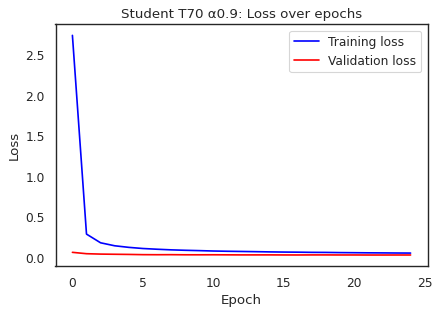


student model valid accuracy: 0.9891
=======> Temperature: 80
=======> Teacher model trained with Temperature 80
07:56:08 --- Epoch: 1	Train loss: 0.2486	Valid loss: 0.1233	Train accuracy: 94.55	Valid accuracy: 96.38
07:56:55 --- Epoch: 3	Train loss: 0.1472	Valid loss: 0.0766	Train accuracy: 96.71	Valid accuracy: 97.77
07:57:42 --- Epoch: 5	Train loss: 0.1105	Valid loss: 0.0605	Train accuracy: 97.29	Valid accuracy: 98.08
07:58:28 --- Epoch: 7	Train loss: 0.0938	Valid loss: 0.0521	Train accuracy: 97.72	Valid accuracy: 98.43
07:59:15 --- Epoch: 9	Train loss: 0.0827	Valid loss: 0.0465	Train accuracy: 98.07	Valid accuracy: 98.49
08:00:01 --- Epoch: 11	Train loss: 0.0767	Valid loss: 0.0441	Train accuracy: 98.16	Valid accuracy: 98.60
08:00:48 --- Epoch: 13	Train loss: 0.0690	Valid loss: 0.0427	Train accuracy: 98.56	Valid accuracy: 98.62
08:01:35 --- Epoch: 15	Train loss: 0.0635	Valid loss: 0.0359	Train accuracy: 98.60	Valid accuracy: 98.80
08:02:22 --- Epoch: 17	Train loss: 0.0588	Valid los

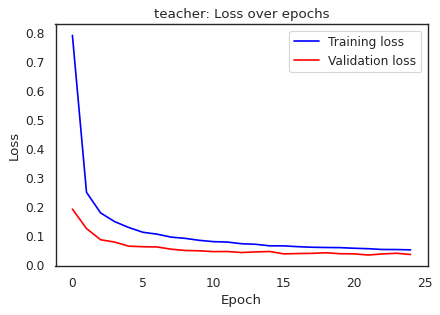

=======> Student model trained with Temperature 80
08:05:48 --- Epoch: 1	Train loss: 0.3035	Valid loss: 0.0493	Train accuracy: 97.67	Valid accuracy: 98.29
08:06:36 --- Epoch: 3	Train loss: 0.1521	Valid loss: 0.0425	Train accuracy: 98.14	Valid accuracy: 98.54
08:07:24 --- Epoch: 5	Train loss: 0.1149	Valid loss: 0.0403	Train accuracy: 98.27	Valid accuracy: 98.62
08:08:13 --- Epoch: 7	Train loss: 0.0983	Valid loss: 0.0401	Train accuracy: 98.40	Valid accuracy: 98.58
08:09:01 --- Epoch: 9	Train loss: 0.0879	Valid loss: 0.0373	Train accuracy: 98.52	Valid accuracy: 98.68
08:09:49 --- Epoch: 11	Train loss: 0.0805	Valid loss: 0.0384	Train accuracy: 98.56	Valid accuracy: 98.64
08:10:38 --- Epoch: 13	Train loss: 0.0752	Valid loss: 0.0379	Train accuracy: 98.59	Valid accuracy: 98.71
08:11:26 --- Epoch: 15	Train loss: 0.0704	Valid loss: 0.0370	Train accuracy: 98.53	Valid accuracy: 98.79
08:12:15 --- Epoch: 17	Train loss: 0.0669	Valid loss: 0.0369	Train accuracy: 98.69	Valid accuracy: 98.66
08:13:03 

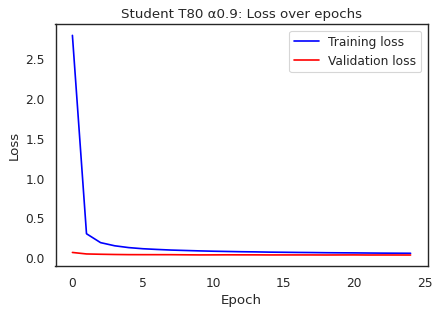


student model valid accuracy: 0.9875
=======> Temperature: 90
=======> Teacher model trained with Temperature 90
08:15:47 --- Epoch: 1	Train loss: 0.2462	Valid loss: 0.1060	Train accuracy: 95.02	Valid accuracy: 96.82
08:16:34 --- Epoch: 3	Train loss: 0.1470	Valid loss: 0.0976	Train accuracy: 96.12	Valid accuracy: 97.02
08:17:21 --- Epoch: 5	Train loss: 0.1135	Valid loss: 0.0610	Train accuracy: 97.35	Valid accuracy: 98.18
08:18:08 --- Epoch: 7	Train loss: 0.0950	Valid loss: 0.0509	Train accuracy: 97.63	Valid accuracy: 98.54
08:18:55 --- Epoch: 9	Train loss: 0.0842	Valid loss: 0.0573	Train accuracy: 97.67	Valid accuracy: 98.03
08:19:42 --- Epoch: 11	Train loss: 0.0768	Valid loss: 0.0450	Train accuracy: 98.20	Valid accuracy: 98.50
08:20:29 --- Epoch: 13	Train loss: 0.0687	Valid loss: 0.0411	Train accuracy: 98.37	Valid accuracy: 98.65
08:21:17 --- Epoch: 15	Train loss: 0.0641	Valid loss: 0.0376	Train accuracy: 98.53	Valid accuracy: 98.84
08:22:04 --- Epoch: 17	Train loss: 0.0594	Valid los

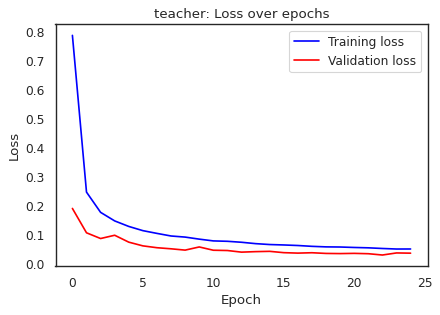

=======> Student model trained with Temperature 90
08:25:31 --- Epoch: 1	Train loss: 0.2913	Valid loss: 0.0508	Train accuracy: 97.69	Valid accuracy: 98.43
08:26:20 --- Epoch: 3	Train loss: 0.1485	Valid loss: 0.0436	Train accuracy: 98.16	Valid accuracy: 98.70
08:27:07 --- Epoch: 5	Train loss: 0.1141	Valid loss: 0.0426	Train accuracy: 98.33	Valid accuracy: 98.70
08:27:56 --- Epoch: 7	Train loss: 0.0984	Valid loss: 0.0414	Train accuracy: 98.41	Valid accuracy: 98.73
08:28:44 --- Epoch: 9	Train loss: 0.0876	Valid loss: 0.0395	Train accuracy: 98.47	Valid accuracy: 98.75
08:29:32 --- Epoch: 11	Train loss: 0.0798	Valid loss: 0.0389	Train accuracy: 98.45	Valid accuracy: 98.82
08:30:20 --- Epoch: 13	Train loss: 0.0744	Valid loss: 0.0378	Train accuracy: 98.53	Valid accuracy: 98.85
08:31:10 --- Epoch: 15	Train loss: 0.0699	Valid loss: 0.0383	Train accuracy: 98.60	Valid accuracy: 98.83
08:31:58 --- Epoch: 17	Train loss: 0.0668	Valid loss: 0.0375	Train accuracy: 98.58	Valid accuracy: 98.81
08:32:46 

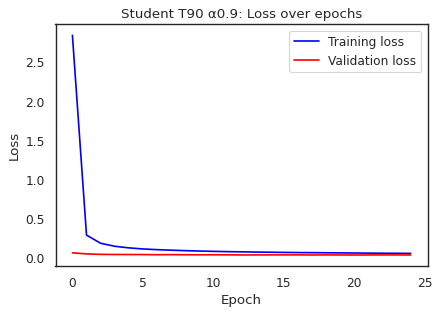


student model valid accuracy: 0.9886
=======> Temperature: 100
=======> Teacher model trained with Temperature 100
08:35:26 --- Epoch: 1	Train loss: 0.2436	Valid loss: 0.1103	Train accuracy: 95.13	Valid accuracy: 96.55
08:36:14 --- Epoch: 3	Train loss: 0.1441	Valid loss: 0.0798	Train accuracy: 96.43	Valid accuracy: 97.42
08:36:59 --- Epoch: 5	Train loss: 0.1148	Valid loss: 0.0591	Train accuracy: 97.28	Valid accuracy: 98.19
08:37:46 --- Epoch: 7	Train loss: 0.0952	Valid loss: 0.0549	Train accuracy: 97.74	Valid accuracy: 98.27
08:38:32 --- Epoch: 9	Train loss: 0.0836	Valid loss: 0.0490	Train accuracy: 98.02	Valid accuracy: 98.41
08:39:18 --- Epoch: 11	Train loss: 0.0777	Valid loss: 0.0438	Train accuracy: 98.26	Valid accuracy: 98.68
08:40:05 --- Epoch: 13	Train loss: 0.0696	Valid loss: 0.0384	Train accuracy: 98.41	Valid accuracy: 98.68
08:40:52 --- Epoch: 15	Train loss: 0.0666	Valid loss: 0.0381	Train accuracy: 98.50	Valid accuracy: 98.72
08:41:39 --- Epoch: 17	Train loss: 0.0605	Valid l

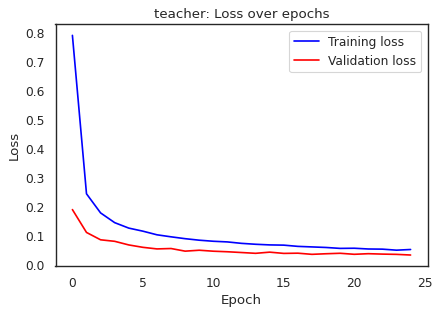

=======> Student model trained with Temperature 100
08:45:04 --- Epoch: 1	Train loss: 0.2890	Valid loss: 0.0496	Train accuracy: 97.63	Valid accuracy: 98.35
08:45:52 --- Epoch: 3	Train loss: 0.1477	Valid loss: 0.0413	Train accuracy: 98.13	Valid accuracy: 98.62
08:46:40 --- Epoch: 5	Train loss: 0.1138	Valid loss: 0.0382	Train accuracy: 98.33	Valid accuracy: 98.75
08:47:27 --- Epoch: 7	Train loss: 0.0971	Valid loss: 0.0373	Train accuracy: 98.41	Valid accuracy: 98.81
08:48:15 --- Epoch: 9	Train loss: 0.0869	Valid loss: 0.0353	Train accuracy: 98.56	Valid accuracy: 98.88
08:49:03 --- Epoch: 11	Train loss: 0.0795	Valid loss: 0.0365	Train accuracy: 98.59	Valid accuracy: 98.80
08:49:51 --- Epoch: 13	Train loss: 0.0739	Valid loss: 0.0351	Train accuracy: 98.55	Valid accuracy: 98.89
08:50:39 --- Epoch: 15	Train loss: 0.0698	Valid loss: 0.0346	Train accuracy: 98.60	Valid accuracy: 98.88
08:51:27 --- Epoch: 17	Train loss: 0.0664	Valid loss: 0.0344	Train accuracy: 98.68	Valid accuracy: 98.86
08:52:15

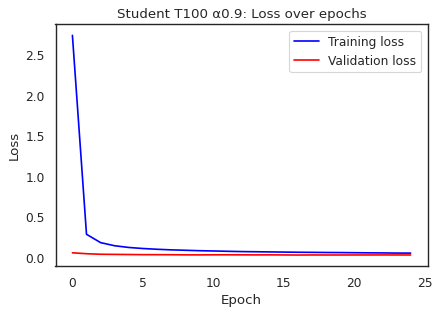


student model valid accuracy: 0.9890


In [22]:
# Train
LEARNING_RATE_T = 0.01
LEARNING_RATE_S = 0.01
N_EPOCHS = 25
ALPHA = 0.9

for T in range(30, 110, 10):
    print(f"=======> Temperature: {T}")
    print(f"=======> Teacher model trained with Temperature {T}")
    model_teacher = LargeNet(N_CLASSES, DROPOUT, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE_T, momentum=0.9)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

    print(f"=======> Student model trained with Temperature {T}")
    model_s_soft = SmallNet(N_CLASSES, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE_S, momentum=0.9)
    
    train_criterion = SoftCrossEntropyLoss(T, ALPHA)
    valid_criterion = nn.CrossEntropyLoss()
    
    prefix = f"student_T{T}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{T} α{ALPHA}"
         }

    model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
    torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")
    
    valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
    print(f"\nstudent model valid accuracy: {valid_acc:.4f}")
